# Sample-based quantum diagonalization of a chemistry Hamiltonian
https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-quantum-diagonalization

In [2]:
# 전부 최신 버전으로 설치하였음.

import sys

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import qiskit_aer
import qiskit_ibm_runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import qiskit_algorithms
import qiskit_addon_sqd

import numpy as np
import scipy
import matplotlib
import importlib.metadata
%matplotlib inline
import matplotlib.pyplot as plt
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim

##############################추가##############################
from typing import Sequence
import rustworkx
from rustworkx import PyGraph, NoEdgeBetweenNodes
from qiskit.providers import BackendV2
##############################추가##############################

print("Python:", sys.version)
print("qiskit:", qiskit.__version__)
print('qiskit_addon_sqd version: ', importlib.metadata.version('qiskit_addon_sqd'))
print("qiskit-aer:", qiskit_aer.__version__)
print("qiskit-ibm-runtime:", qiskit_ibm_runtime.__version__)
print("qiskit-algorithms:", qiskit_algorithms.__version__)
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)
print("matplotlib:", matplotlib.__version__)
print("pyscf:", pyscf.__version__)
print('ffsim:', importlib.metadata.version('ffsim'))

Python: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:56:31) [Clang 19.1.7 ]
qiskit: 2.2.3
qiskit_addon_sqd version:  0.12.0
qiskit-aer: 0.17.2
qiskit-ibm-runtime: 0.43.1
qiskit-algorithms: 0.4.0
numpy: 2.3.5
scipy: 1.16.3
matplotlib: 3.10.8
pyscf: 2.11.0
ffsim: 0.0.61


# 고전 화학 계산

In [3]:
open_shell = False # Closed Shell: 최종 솔루션에서 RHF 그라운드 스테이트가 가장 큰 비중을 차지함
spin_sq = 0 # 총 스핀 제곱(S^2)이 0인 Singlet state

# gto: Gaussian type orbitals
# Mole() : 분자 객체
mol = pyscf.gto.Mole()

# N2 분자 생성
mol.build(
    # 질소 원자의 위치 x축 1 옹스트롬
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    
    # cc-pvdz: 기저함수, sto-3g보다 정확도 높은 표준 기저 함수 중 하나
    basis="cc-pvdz",
    
    # D-infinitiy-h 대칭성 :계산을 효율적으로 하게 함
    # D: 주축(x축)
    # infinite: 축을따라 임의의 각도로 돌려도 대칭임
    # h: horizontal, N끼리 거울면 대칭
    symmetry="Dooh",
)

# Active Space 정의
# 가장 에너지 낮은 2개의 sptial orbital 동결 (4개의 큐빗 아낌)
# 공간 오비탈 28 -> 26 (큐빗 56 -> 52)
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr()) # mol.nao_nr(): 전체 공간 오비탈의 수

# 생성된 mol 기반으로 RHF(restrict Hartree-Fock) 계산: 분자 오비탈 계산
# scf.mo_coeff: 계산된 분자 오비탈 (MO)이 어떤 원자 오비탈(AO)의 조합으로 이루어져 있는지 나타내는 계수 행렬
# scf.mo_energy: 각 분자 오비탈의 에너지
# scf.mo_occ: 각 분자 오비탈에 전자가 몇 개 채워졌는지 (0.0 또는 2.0) 나타냄 (낮은 에너지부터 채워짐)
# Output: RHF 에너지(하나의 Slater Determinant로 근사), converged SCF energy = ...
scf = pyscf.scf.RHF(mol).run() 

num_orbitals = len(active_space) # 26: 낮은 에너지부터 0번
n_electrons = int(sum(scf.mo_occ[active_space])) # 총 전자 개수 = 10

# Open Shell 이면 계산 달라짐
num_elec_a = (n_electrons + mol.spin) // 2 # 업스핀 수
num_elec_b = (n_electrons - mol.spin) // 2 # 다운스핀 수

# MCSCF(Multi-Configurational Self-Consistent Field) (RHF, 또는 SCF) 방법보다 더 정확하고 강력한 상위 레벨의 양자 화학 계산법
# CASCI (Complete Active Space CI): MCSCF의 한 종류
# CASCI (Complete Active Space Configuration Interaction, 완전 활성 공간 배치 상호작용) 기능을 사용하기 위한 객체(cas) 생성
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))

mo = cas.sort_mo(active_space, base=0) # 활성 공간 오비탈 골라내고 정렬, 활성오비탈 0번부터 시작

# 1전자 적분 h_pq 계산
# nuclear_repulsion_energy: 핵과 핵 사이의 반발 에너지입, 분자가 고정되어 있으므로 이 값은 상수
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)

# cas.get_h2cas(mo): 2전자 적분 (pq|rs) 계산 -> 1차원 배열로 반환
# pyscf.ao2mo.restore: 1차원 배열을 4차원 텐서(26 26 26 26)로 복원
# 1: 4차원 텐서로 복원하라는 옵션
# num_orbitals: 복원할 텐서의 크기
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# 26개 오비탈 문제를 고전 컴퓨터에서 정밀한 방식(SCI)으로 미리 계산해 둔 벤치마크 값
exact_energy = -109.22690201485733

converged SCF energy = -108.929838385609


In [4]:
# LUCJ 회로에 사용할 파라미터를 고전 컴퓨터로 계산
# pyscf.cc.CCSD(...): PySCF의 CCSD(coupled cluster singles and doubles) 계산 준비
# scf: reference state로 rhf 계산 결과를 참조
# frozen: 동결시킬 오비탈
# Output: CCSD 방법으로 근사한 그라운드 스테이트 에너지와 E_ccsd - E_RHF 값
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()

# t1, t2가 K, J 계수들을 만들기 위한 재료
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.2177884185544  E_corr = -0.2879500329450042


# 양자 샘플링

In [5]:
# ffsim과 qiskit을 이용한 양자 회로 설계

n_reps = 1 # 회로 레이어

# 텀들중에서 ibm의 heavy-hex 구조에 맞는 상호작용만 남김
# Gemini:
    # (p, p+1), (p, p) 도 서로 에너지가 가까운 오비탈이지만, 그렇다고 계산에 반드시 중요한 텀이라는것은 아님
    # 이 또한 ibm topology에 맞추기 위한것
    # 중요성을 t2 진폭의 크기를 기준으로 판단하는게 나을것
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)] # 같은 스핀끼리 상호작용 쌍 정의
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)] # 다른 스핀끼리 상호작용 쌍 정의

# ucj_op: UCJ 회로를 나타내는 operator 생성
# UCJOpSpinBalanced: 스핀 밸런스드 -> J나 K에 스핀 인덱스가 없음, 업스핀 다운스핀이 같음
# from_t_amplitudes: 이 연산자들을 t 진폭으로부터 만든다
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    # t2 텐서를 최적화(압축)하고, 압축된 t2를 통해 K와 J를 계산함
    optimize=True,
    # t2 텐서 최적화를 1000번 안쪽으로만 함
    options=dict(maxiter=1000),
)

nelec = (num_elec_a, num_elec_b)

########## reset-mitigation 적용 ##########
from qiskit import ClassicalRegister

# create an empty quantum circuit
n_qubits = 2 * num_orbitals
qubits = QuantumRegister(n_qubits, name="q")

# Reset-mitigation용: (1) 첫 측정(pre) (2) 마지막 측정(meas) 레지스터를 분리
cr_pre = ClassicalRegister(n_qubits, name="pre")    # 첫 측정 (초기화 검사)
cr_meas = ClassicalRegister(n_qubits, name="meas")  # 마지막 측정 (SQD 입력)

circuit = QuantumCircuit(qubits, cr_pre, cr_meas)

# (NEW) reset-mitigation: 회로 실행 전에 한 번 더 측정
# 이후 classical postselection에서 pre == |0...0> 인 샷만 남길 것
circuit.measure(qubits, cr_pre)
circuit.barrier()

# 기존대로 state prep + ansatz
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

# 최종 측정
circuit.barrier()
circuit.measure(qubits, cr_meas)



In [ ]:
QiskitRuntimeService.save_account(
    token="IBM_QUANTUM_TOKEN",
    instance="IBM_QUANTUM_INSTANCE",
    overwrite=True,
    set_as_default=True
)

service = QiskitRuntimeService()
print(service.backends())
backend_name = "ibm_fez"
backend = service.backend(backend_name)
print(backend)

[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>]
<IBMBackend('ibm_fez')>


In [7]:
##############################추가 시작##############################
IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}


def _create_linear_chains(num_orbitals: int) -> PyGraph:
    """스핀-업 체인 하나, 스핀-다운 체인 하나: 총 2*num_orbitals 노드를 가진 두 개의 직선 체인 그래프."""
    G = PyGraph()

    # alpha 체인: 0 .. num_orbitals-1
    for n in range(num_orbitals):
        G.add_node(n)
    for n in range(num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    # beta 체인: num_orbitals .. 2*num_orbitals-1
    for n in range(num_orbitals, 2 * num_orbitals):
        G.add_node(n)
    for n in range(num_orbitals, 2 * num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    return G


def _create_lucj_zigzag_layout(
    num_orbitals: int, backend_coupling_graph: PyGraph
) -> tuple[PyGraph, int]:
    """
    LUCJ에 맞는 '가상' 지그재그 그래프를 만들고,
    이 그래프가 백엔드 coupling graph의 서브그래프가 되도록 브리지(α-β) 개수를 조정한다.
    반환값:
        G_new: 백엔드와 호환 가능한 지그재그 그래프
        num_alpha_beta_qubits: 사용된 브리지(α-β) 노드 수
    """
    isomorphic = False
    base_graph = _create_linear_chains(num_orbitals)
    num_iters = num_orbitals  # 최대 num_orbitals/4 개 지점까지 브리지 시도

    while not isomorphic and num_iters > 0:
        G_new = base_graph.copy()
        num_alpha_beta_qubits = 0

        # p = 0, 4, 8, ... 에서 브리지 노드를 추가.
        # 단, n < num_iters 로 제한을 둬서 브리지 개수를 줄여가며 시도.
        for n in range(num_iters):
            if n % 4 == 0:
                new_node = 2 * num_orbitals + num_alpha_beta_qubits
                G_new.add_node(new_node)
                # alpha-체인 쪽과 연결
                G_new.add_edge(n, new_node, None)
                # beta-체인 쪽과 연결
                G_new.add_edge(n + num_orbitals, new_node, None)
                num_alpha_beta_qubits += 1

        isomorphic = rustworkx.is_subgraph_isomorphic(
            backend_coupling_graph, G_new
        )
        num_iters -= 1

    return G_new, num_alpha_beta_qubits


def _lightweight_layout_error_scoring(
    backend: BackendV2,
    virtual_edges: Sequence[Sequence[int]],
    physical_layouts: Sequence[list[int]],
    two_q_gate_name: str,
) -> list[tuple[list[int], float]]:
    """
    가능한 zigzag 레이아웃들(서브그래프 embedding) 중에서,
    2Q gate error + readout error 합이 가장 작은 레이아웃을 고르기 위한 점수 계산.
    """
    props = backend.properties()
    scores: list[tuple[list[int], float]] = []

    for layout in physical_layouts:
        total_2q_error = 0.0
        for u, v in virtual_edges:
            phys_edge = (layout[u], layout[v])
            try:
                ge = props.gate_error(two_q_gate_name, phys_edge)
            except Exception:
                # 방향 반대일 수도 있으니 한번 더 시도
                ge = props.gate_error(two_q_gate_name, phys_edge[::-1])
            total_2q_error += ge

        total_meas_error = 0.0
        for q in layout:
            total_meas_error += props.readout_error(q)

        scores.append((layout, total_2q_error + total_meas_error))

    # 점수가 작은(= 노이즈가 적은) 순으로 정렬
    scores.sort(key=lambda x: x[1])
    return scores


def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    """
    Backend의 CouplingMap을 무방향 PyGraph로 바꾸고, 중복 edge 제거.
    """
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()

    backend_graph = graph.to_undirected()
    seen_edges: set[tuple[int, int]] = set()

    for u, v in list(backend_graph.edge_list()):
        key = tuple(sorted((u, v)))
        if key in seen_edges:
            try:
                backend_graph.remove_edge(u, v)
            except NoEdgeBetweenNodes:
                pass
        else:
            seen_edges.add(key)

    return backend_graph


def get_zigzag_physical_layout(
    num_orbitals: int, backend: BackendV2, score_layouts: bool = True
) -> tuple[list[int], int]:
    """
    LUCJ용 지그재그 패턴을 가진 물리 큐빗 레이아웃을 생성.
    반환:
        initial_layout: 길이 2*num_orbitals 인 리스트 (각 논리 큐빗 → 물리 큐빗 인덱스)
        num_alpha_beta_qubits: 브리지(α-β 상호작용용) 노드 수
    """
    backend_graph = _make_backend_cmap_pygraph(backend)

    # 1) 백엔드와 호환되는 가상 지그재그 그래프 만들기
    zigzag_graph, num_alpha_beta_qubits = _create_lucj_zigzag_layout(
        num_orbitals=num_orbitals,
        backend_coupling_graph=backend_graph,
    )

    # 2) 해당 그래프가 백엔드 그래프의 어떤 서브그래프로 들어가는지 모든 매핑 찾기
    mappings = list(
        rustworkx.vf2_mapping(
            backend_graph,
            zigzag_graph,
            subgraph=True,
        )
    )

    virtual_edges = list(zigzag_graph.edge_list())
    layouts: list[list[int]] = []

    # rustworkx.vf2_mapping 은 {backend_node: virtual_node} 딕셔너리들을 반환.
    for mapping in mappings:
        layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for backend_node, virtual_node in mapping.items():
            layout[virtual_node] = backend_node
        layouts.append(layout)

    # 백엔드의 2Q 게이트 이름 선택 (cx/ecr/cz 중 하나)
    two_q_gate_name = IBM_TWO_Q_GATES.intersection(
        backend.configuration().basis_gates
    ).pop()

    if score_layouts:
        scores = _lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=virtual_edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )
        best_layout, _ = scores[0]
    else:
        best_layout = layouts[0]

    # 맨 뒤 num_alpha_beta_qubits 개는 "브리지 노드"에 해당 → 스핀오비탈용 논리 큐빗만 남김
    return best_layout[:-num_alpha_beta_qubits], num_alpha_beta_qubits
##############################추가 끝##############################

##############################교체 시작##############################
# 1) 지그재그 물리 레이아웃 계산
initial_layout, num_alpha_beta = get_zigzag_physical_layout(
    num_orbitals=num_orbitals,
    backend=backend,
)

print("Initial zigzag layout:", initial_layout)
print("Number of alpha-beta bridge nodes (unused ancilla qubits):", num_alpha_beta)

# 2) 이 레이아웃을 사용하는 pass manager 생성
pm = generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
    initial_layout=initial_layout,
)

# 3) ffsim PRE_INIT 패스를 pre_init 단계에 붙여서 LUCJ 회로를 더 잘 줄이기
pm.pre_init = ffsim.qiskit.PRE_INIT

# 4) 회로 트랜스파일
isa_circ = pm.run(circuit)

# 5) 샘플러로 실행
sampler = Sampler(mode=backend)
job = sampler.run([isa_circ], shots=100_000)
print(f">>> Job ID: {job.job_id()}")
##############################교체 끝##############################

Initial zigzag layout: [15, 19, 35, 34, 33, 39, 53, 52, 51, 58, 71, 70, 69, 78, 89, 88, 87, 97, 107, 106, 105, 117, 125, 124, 123, 136, 13, 12, 11, 18, 31, 30, 29, 38, 49, 48, 47, 57, 67, 66, 65, 77, 85, 84, 83, 96, 103, 102, 101, 116, 121, 120]
Number of alpha-beta bridge nodes (unused ancilla qubits): 7
>>> Job ID: d57sp0fp3tbc73aqjm40


In [8]:
job = service.job("d57sp0fp3tbc73aqjm40")
result = job.result()

# SamplerV2 결과: 각 classical register마다 BitArray가 하나씩 나옴
data0 = result[0].data
pre = data0.pre    # 첫 측정 결과
meas = data0.meas  # 마지막 측정 결과 (SQD에 넣을 것)

# --- reset-mitigation postselection ---
# 첫 측정이 |0...0> 인 샷만 남김
zero = "0" * pre.num_bits
pre_bitstrings = pre.get_bitstrings()
meas_bitstrings = meas.get_bitstrings()

kept_shots = [i for i, s in enumerate(pre_bitstrings) if s == zero]

# 같은 shot 인덱스로 최종 측정(meas)만 필터링해서 count로 사용
count = meas.slice_shots(kept_shots)

print(
    f"[reset-mitigation] kept {len(kept_shots)} / {len(meas_bitstrings)} shots "
    f"({len(kept_shots) / len(meas_bitstrings):.3f} retention)"
)

count


[reset-mitigation] kept 50043 / 100000 shots (0.500 retention)


BitArray(<shape=(), num_shots=50043, num_bits=52>)

# Configuration Recovery 및 결과

In [9]:
from functools import partial

from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# 추가: BitArray → 배열 변환 + Hamming postselection
from qiskit_addon_sqd.counts import bit_array_to_arrays
from qiskit_addon_sqd.subsampling import postselect_by_hamming_right_and_left

# SQD 이터레이션 중지 조건
energy_tol = 1e-3          # 에너지 변화
occupancies_tol = 1e-3     # 오비탈 점유율 n, ( n_(i+1)-n_(i) )의 infinite norm으로 정의
max_iterations = 5         # 최대 반복 횟수

# Batch와 대각화 관련 옵션
num_batches = 3 # Batch의 수 (K)
samples_per_batch = 300 # Batch의 크기
symmetrize_spin = True # 스핀 대칭성 고려 결과 개선
# configuration recovery를 위한 샘플링때 계수가 큰 bitstring들을 다음 이터레이션을 위한 샘플링에 추가
carryover_threshold = 1e-4 
max_cycle = 200 # Davidson 알고리즘등의 반복을 200번으로 제한

# spin_sq = 0.0: 스핀 symmetry 관련 패널티항 추가 
# H + lambda(S^2 + s(s+1))^2 여기서 s(s+1)=0 을 넣는다는 뜻
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)
result_history = []

# 결과 출력용 함수
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )

# --- HF 기반 initial n: 노이즈 심해서 유효 샘플이 0개일 때만 쓸 예정 ---
initial_occupancies_spin_orbital = np.zeros(2 * num_orbitals)
initial_occupancies_spin_orbital[:num_elec_a] = 1.0
initial_occupancies_spin_orbital[
    num_orbitals : num_orbitals + num_elec_b
] = 1.0

# --- 1) BitArray에서 raw 샘플 개수 / 유효 샘플 개수 계산 ---

# BitArray(count) -> bitstring_matrix (bool), probabilities
bitstring_matrix, probabilities = bit_array_to_arrays(count)

num_raw_samples = bitstring_matrix.shape[0]
print(f"[SQD] Total raw samples from hardware: {num_raw_samples}")

# 비트스트링 형식: [b_N, ..., b_0, a_N, ..., a_0]
# → 오른쪽 절반(α)의 Hamming weight = num_elec_a
#   왼쪽 절반(β)의 Hamming weight = num_elec_b
bitstring_matrix_valid, probabilities_valid = postselect_by_hamming_right_and_left(
    bitstring_matrix,
    probabilities,
    hamming_right=num_elec_a,
    hamming_left=num_elec_b,
)

num_valid_samples = bitstring_matrix_valid.shape[0]
print(
    f"[SQD] Valid samples after (Nα={num_elec_a}, Nβ={num_elec_b}) postselection: "
    f"{num_valid_samples}"
)

# --- 2) initial_occupancies 선택 로직 ---

if num_valid_samples == 0:
    print(
        "[SQD] WARNING: No valid samples found. "
        "Falling back to HF-based initial occupancies."
    )
    initial_occupancies_for_sqd = initial_occupancies_spin_orbital
else:
    print(
        "[SQD] Using tutorial-style SQD: "
        "no explicit initial_occupancies (first n is inferred from samples)."
    )
    initial_occupancies_for_sqd = None

# --- 3) SQD 실행 ---

result = diagonalize_fermionic_hamiltonian(
    hcore,                      # 1-전자 적분 (활성 공간)
    eri,                        # 2-전자 적분 (활성 공간)
    count,                      # 양자 측정 결과 (BitArray 객체)
    samples_per_batch=samples_per_batch,    # 배치당 샘플 수 (300)
    norb=num_orbitals,          # 활성 공간 오비탈 수 (26)
    nelec=nelec,                # 활성 공간 전자 수 ((5, 5))
    num_batches=num_batches,    # 배치 수 (3)
    energy_tol=energy_tol,      # 에너지 수렴 기준 (0.001)
    occupancies_tol=occupancies_tol,  # n 수렴 기준 (0.001), l maximum norm
    max_iterations=max_iterations,    # 최대 반복 횟수 (5)
    sci_solver=sci_solver,      # 계산 함수 위에서 partial 통해서 정의
    symmetrize_spin=symmetrize_spin,    # 스핀 inversion symmetry 고려 방법 사용 (sqrt(d)/2개 뽑아서)
    carryover_threshold=carryover_threshold,    # 중요 배치 유지 기준 (1e-4)
    callback=callback,                          # 반복 시 호출될 함수
    seed=12345,                                 # 재현성을 위한 랜덤 시드
    # initial n: 설정조건부로 HF / None 선택
    initial_occupancies=initial_occupancies_for_sqd,
)

[SQD] Total raw samples from hardware: 50043
[SQD] Valid samples after (Nα=5, Nβ=5) postselection: 102
[SQD] Using tutorial-style SQD: no explicit initial_occupancies (first n is inferred from samples).
Iteration 1
	Subsample 0
		Energy: -108.95779441317421
		Subspace dimension: 38416
	Subsample 1
		Energy: -108.95779441317421
		Subspace dimension: 38416
	Subsample 2
		Energy: -108.95779441317421
		Subspace dimension: 38416
Iteration 2
	Subsample 0
		Energy: -109.11653880795977
		Subspace dimension: 316969
	Subsample 1
		Energy: -109.08509953140464
		Subspace dimension: 310249
	Subsample 2
		Energy: -109.0704867393307
		Subspace dimension: 298116
Iteration 3
	Subsample 0
		Energy: -109.14807420730783
		Subspace dimension: 499849
	Subsample 1
		Energy: -109.16606653243844
		Subspace dimension: 467856
	Subsample 2
		Energy: -109.15922889574506
		Subspace dimension: 519841
Iteration 4
	Subsample 0
		Energy: -109.17708462617124
		Subspace dimension: 692224
	Subsample 1
		Energy: -109.17664

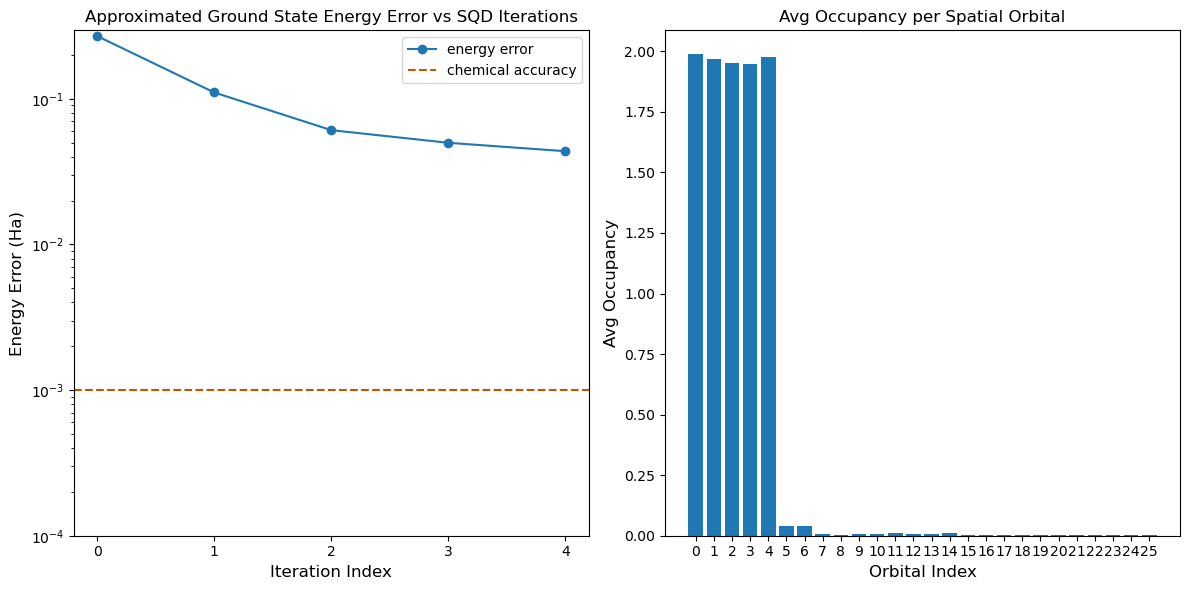

In [10]:
# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()
 
# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
 
plt.tight_layout()
plt.show()

=== Alpha spin orbitals (0 .. num_orbitals-1) ===
α orbital  0  →  physical qubit 15
α orbital  1  →  physical qubit 19
α orbital  2  →  physical qubit 35
α orbital  3  →  physical qubit 34
α orbital  4  →  physical qubit 33
α orbital  5  →  physical qubit 39
α orbital  6  →  physical qubit 53
α orbital  7  →  physical qubit 52
α orbital  8  →  physical qubit 51
α orbital  9  →  physical qubit 58
α orbital 10  →  physical qubit 71
α orbital 11  →  physical qubit 70
α orbital 12  →  physical qubit 69
α orbital 13  →  physical qubit 78
α orbital 14  →  physical qubit 89
α orbital 15  →  physical qubit 88
α orbital 16  →  physical qubit 87
α orbital 17  →  physical qubit 97
α orbital 18  →  physical qubit 107
α orbital 19  →  physical qubit 106
α orbital 20  →  physical qubit 105
α orbital 21  →  physical qubit 117
α orbital 22  →  physical qubit 125
α orbital 23  →  physical qubit 124
α orbital 24  →  physical qubit 123
α orbital 25  →  physical qubit 136

=== Beta spin orbitals (0 .. nu

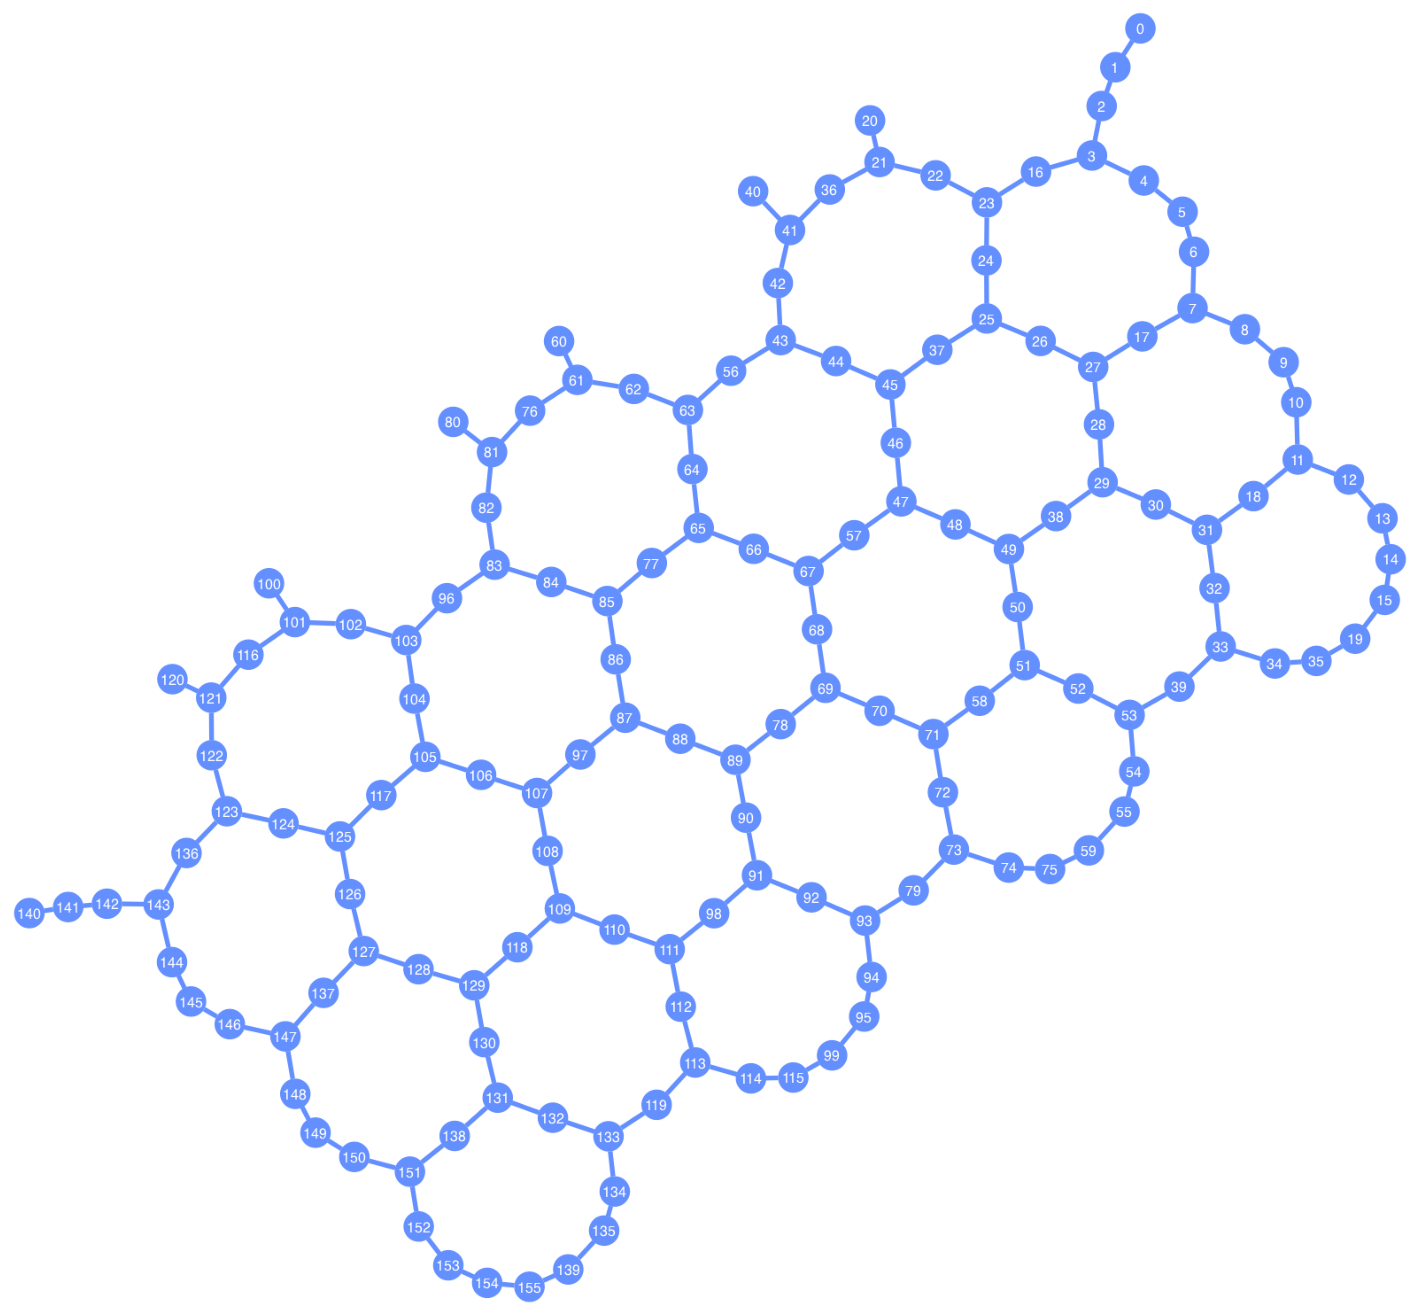

saved coupling_map.png


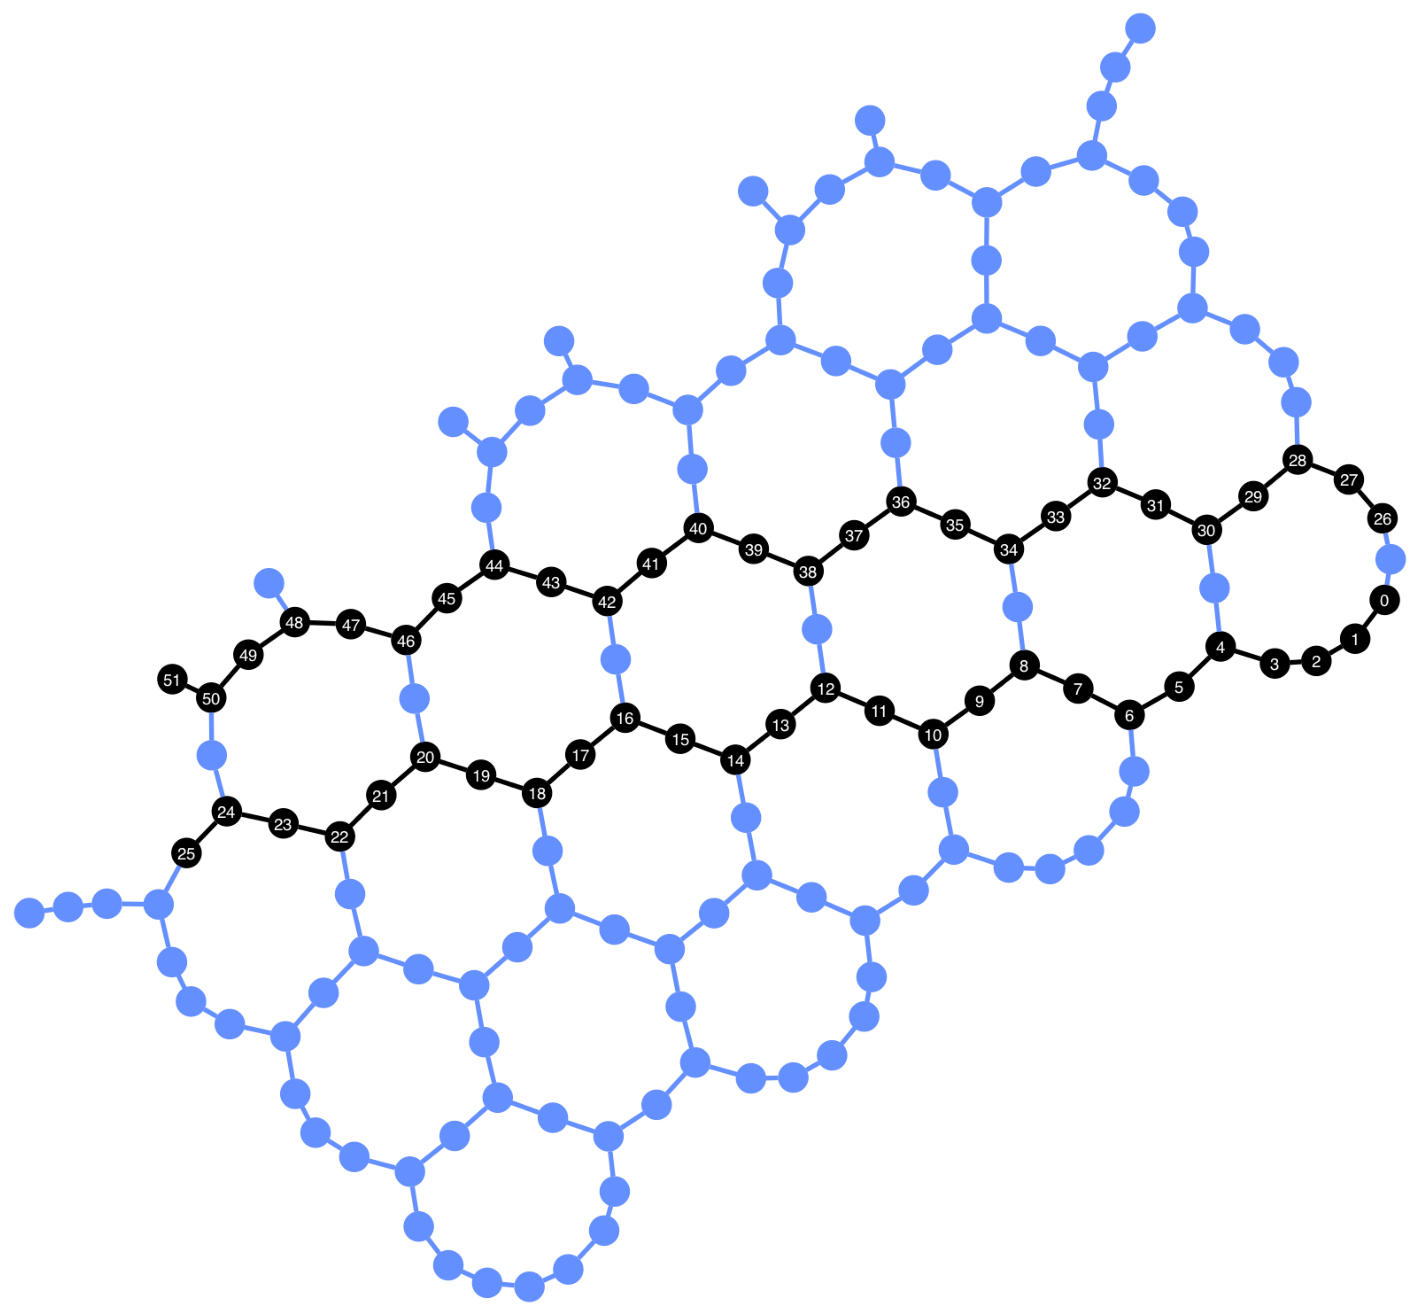

saved circuit_layout.png


In [11]:
# --- 1. 텍스트로 매핑 확인 ---

print("=== Alpha spin orbitals (0 .. num_orbitals-1) ===")
for p in range(num_orbitals):
    print(f"α orbital {p:2d}  →  physical qubit {initial_layout[p]}")

print("\n=== Beta spin orbitals (0 .. num_orbitals-1) ===")
for p in range(num_orbitals):
    vq = num_orbitals + p
    print(f"β orbital {p:2d}  →  physical qubit {initial_layout[vq]}")


# --- 2. 백엔드 coupling map 시각화 ---

from qiskit.visualization import plot_coupling_map

# BackendV2에서 CouplingMap, edges 가져오기
cm = backend.coupling_map              # CouplingMap 객체
num_q = cm.size()                      # qubit 개수
edges = cm.get_edges()                 # [(u, v), ...] 형태

# qubit_coordinates=None 으로 두면 Qiskit이 알아서 배치해 줌
fig1 = plot_coupling_map(
    num_qubits=num_q,
    qubit_coordinates=None,
    coupling_map=edges,
)
plt.show()              # 노트북 셀 안에 바로 표시
fig1.savefig("coupling_map.png", dpi=200)   # 혹시 안 보이면 파일로도 저장
print("saved coupling_map.png")


# --- 3. 트랜스파일된 회로의 레이아웃 시각화 ---

from qiskit.visualization import plot_circuit_layout

fig2 = plot_circuit_layout(isa_circ, backend=backend)
plt.show()
fig2.savefig("circuit_layout.png", dpi=200)
print("saved circuit_layout.png")